In [102]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

from itertools import combinations

# fetch dataset 
abalone_dataset = fetch_ucirepo(id=1) 

X = abalone_dataset.data.features
y = abalone_dataset.data.targets 

In [103]:
X.shape, y.shape

((4177, 8), (4177, 1))

In [104]:
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


Length               Axes(0.125,0.798085;0.168478x0.0819149)
Diameter          Axes(0.327174,0.798085;0.168478x0.0819149)
Height            Axes(0.529348,0.798085;0.168478x0.0819149)
Whole_weight      Axes(0.731522,0.798085;0.168478x0.0819149)
Shucked_weight       Axes(0.125,0.699787;0.168478x0.0819149)
Viscera_weight    Axes(0.327174,0.699787;0.168478x0.0819149)
Shell_weight      Axes(0.529348,0.699787;0.168478x0.0819149)
dtype: object

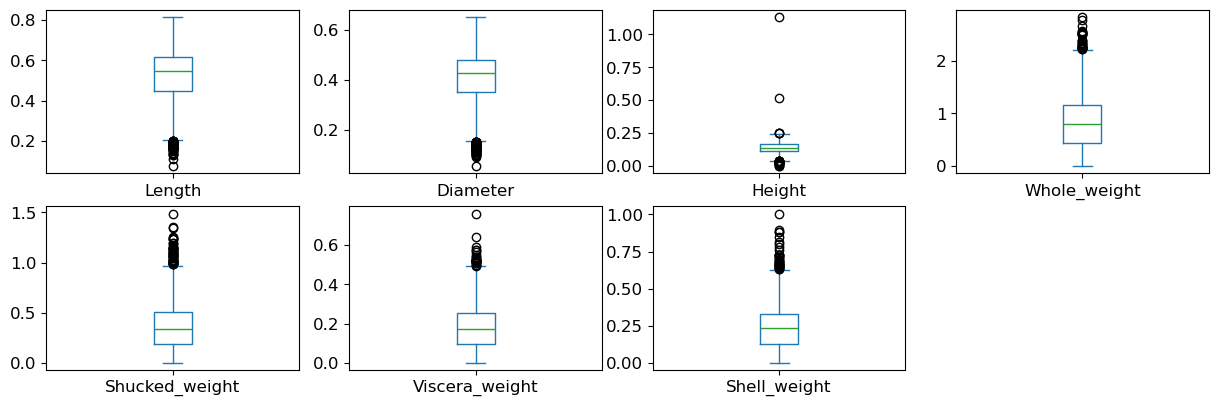

In [105]:
data_mean = X.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(8,4), sharex=False,
sharey=False, fontsize=12, figsize=(15,20))

### Encode 'sex' column

In [106]:
le = LabelEncoder()
data_mean['Sex'] = le.fit_transform(data_mean['Sex'])

### Outlier Removal

In [107]:
outlier_indices = set()
for column in data_mean.columns:
  Q1 = data_mean[column].quantile(0.25)
  Q3 = data_mean[column].quantile(0.75)
  IQR = Q3 - Q1
  
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  
  outliers = data_mean[(data_mean[column] < lower_bound) | (data_mean[column] > upper_bound)].index
  outlier_indices.update(outliers)
  
  outliers_sum = ((data_mean[column] < lower_bound) | (data_mean[column] > upper_bound)).sum()
  print(f'{column}: {outliers_sum} outliers')

outlier_indices = list(outlier_indices)

outlier_rm_x = data_mean.drop(index=outlier_indices)
outlier_rm_y = y.drop(index=outlier_indices)

Sex: 0 outliers
Length: 49 outliers
Diameter: 59 outliers
Height: 29 outliers
Whole_weight: 30 outliers
Shucked_weight: 48 outliers
Viscera_weight: 26 outliers
Shell_weight: 35 outliers


<Axes: >

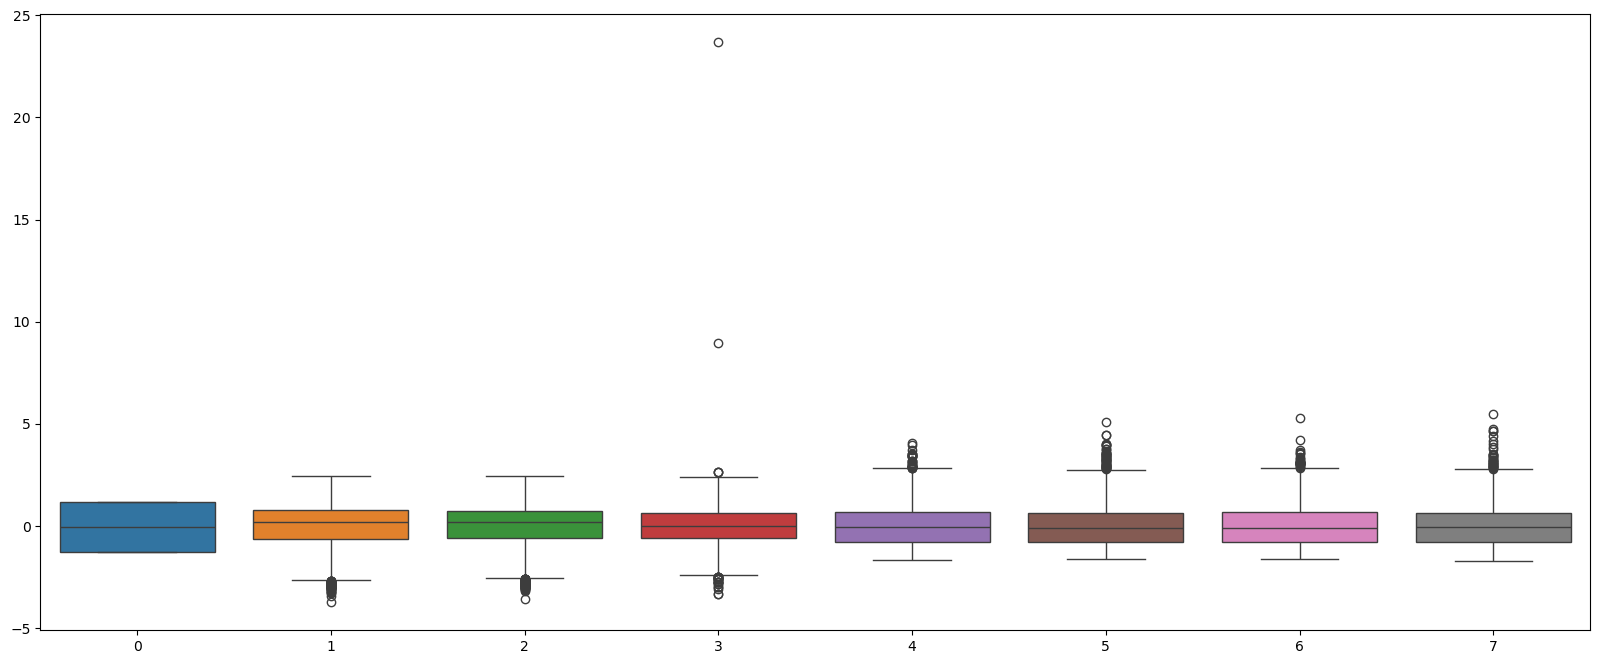

In [108]:
scaler = StandardScaler()
Xs = scaler.fit_transform(data_mean)

# Print features normalised (Xs)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=Xs,ax=ax)

In [109]:
# use outlier removed data
# Xs_train, Xs_test, y_train, y_test = train_test_split(outlier_rm_x, outlier_rm_y.values.ravel(), test_size=0.2, random_state=1)

# use original data
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y.values.ravel(), test_size=0.1, random_state=1)

### Base SVM regression with arbitrary hyper-params

In [110]:
from sklearn.svm import SVR

svr_model = SVR(C=1.0, kernel='rbf', degree=3, gamma='auto')
svr_model.fit(Xs_train, y_train.ravel())

# Step 5: Make predictions and evaluate the model
y_pred = svr_model.predict(Xs_test)
r2 = r2_score(y_test, y_pred)
print('Test MSE: ', mean_squared_error(y_test, y_pred))
print(f"R-squared: {r2}")

Test MSE:  4.5360961266836
R-squared: 0.5364534958262792


### K-fold cross validation

In [111]:
### K-Fold Cross Validation
from sklearn.model_selection import KFold, cross_val_score

n_splits = 5
scores = cross_val_score(svr_model, Xs_train, y_train, cv=n_splits, scoring='neg_mean_squared_error')
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)

print(mse_scores) 
avg = (100 * np.mean(mse_scores), 100 * np.std(mse_scores)/np.sqrt(mse_scores.shape[0])) 
print("Average score and standard deviation: (%.2f +- %.3f)%%"  %avg) 
print("-----------------------------")
print(f"RMSE scores: {rmse_scores}")
print(f"RMSE: {rmse_scores.mean()}")

[4.75654429 5.68001554 4.2921821  4.97440073 4.41711498]
Average score and standard deviation: (482.41 +- 21.985)%
-----------------------------
RMSE scores: [2.18095032 2.38327832 2.07175821 2.23033646 2.10169336]
RMSE: 2.193603334640974


In [112]:
kf = KFold(n_splits=5) 
for train_indicies, test_indicies in kf.split(Xs_train, y_train): 
    svr = SVR(kernel='rbf', C=100, gamma='auto', epsilon=.1) 

    ## NOTE: in this case, outlier removed data and original data have similar performance
    
    # use outlier removed
    # svr.fit(Xs_train.iloc[train_indicies], y_train[train_indicies]) 
    # y_pred = svr.predict(Xs_train.iloc[test_indicies])
    # score = mean_squared_error(y_train[test_indicies], y_pred)
    # r2 = r2_score(y_train[test_indicies], y_pred)

    ## use original
    svr.fit(Xs_train[train_indicies], y_train[train_indicies]) 
    y_pred = svr.predict(Xs_train[test_indicies])
    score = mean_squared_error(y_train[test_indicies], y_pred)
    r2 = r2_score(y_train[test_indicies], y_pred)
    
    print('The MSE value is {:03.2f}'.format(score))
    print('The R2 score is {:03.2f}'.format(r2))
    print('---------------------------------')

The MSE value is 4.61
The R2 score is 0.54
---------------------------------
The MSE value is 5.91
The R2 score is 0.49
---------------------------------
The MSE value is 4.27
The R2 score is 0.58
---------------------------------
The MSE value is 5.28
The R2 score is 0.50
---------------------------------
The MSE value is 4.31
The R2 score is 0.56
---------------------------------


### (Extended) Use GridSearch to find best hyper-parameters

In [113]:
from sklearn.model_selection import GridSearchCV

model = SVR()

param_grid = {
  'C': [0.1, 1, 10, 100],
  # 'gamma': [1, 0.1, 0.01, 0.001],
  'gamma': [1, 0.1, 0.01],
  # 'kernel': ['rbf', 'poly', 'sigmoid'],
  # 'kernel': ['rbf', 'poly'],
  'kernel': ['rbf', ],
  # 'epsilon': [0.1, 0.01, 0.001]
  'epsilon': [0.1, 0.01]
}

grid_search = GridSearchCV(model, param_grid, cv=n_splits, scoring='neg_mean_squared_error')

grid_search.fit(Xs_train, y_train)

# Get the best parameters and the best score
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
best_kernel = grid_search.best_params_['kernel']
best_epsilon = grid_search.best_params_['epsilon']

best_score = -grid_search.best_score_  # Convert from negative MSE to positive MSE

print(f"Best C: {best_C}")
print(f"Best gamma: {best_gamma}")
print(f"Best kernel: {best_kernel}")
print(f"Best epsilon: {best_epsilon}")
print(f"Best MSE: {best_score}")

Best C: 10
Best gamma: 0.1
Best kernel: rbf
Best epsilon: 0.1
Best MSE: 4.601326694535873


### MLP Neural Network

In [114]:
# MLP Neural Network

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming Xs and y are already defined as the feature matrix and target vector
# Example: Xs = <your_feature_matrix>, y = <your_target_values>

# Define the MLP Regressor model
mlp_reg = MLPRegressor(random_state=1, max_iter=300)

# Number of folds for cross-validation
n_folds = 5

# Generate cross-validated predictions across all folds
y_pred = cross_val_predict(mlp_reg, Xs, y, cv=n_folds)

# Calculate the Mean Squared Error (MSE) for the combined predictions
mse = mean_squared_error(y, y_pred)

# Print the overall MSE of the model
print("Mean Squared Error (MSE): {:.2f}".format(mse))


/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterati

Mean Squared Error (MSE): 4.77


/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Base Decision Tree Regression with Arbitrary max_depth

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=4)
tree_reg.fit(Xs_train, y_train)

y_test_pred = tree_reg.predict(Xs_test)

print('Test MSE: ', mean_squared_error(y_test, y_test_pred))
print('Test R^2: ', r2_score(y_test, y_test_pred))

Test MSE:  5.89109767796173
Test R^2:  0.39798503865445944


### K-Fold Validation

In [116]:
### K-Fold Cross Validation
from sklearn.model_selection import KFold, cross_val_score

n_splits = 5
tree_reg = DecisionTreeRegressor(max_depth=4)

scores = cross_val_score(tree_reg, Xs_train, y_train, cv=n_splits, scoring='neg_mean_squared_error')
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)

print("RMSE scores:", mse_scores)
print(f"RMSE: {rmse_scores.mean()}")


RMSE scores: [5.46357838 6.8746133  5.57967516 6.06035691 5.41673835]
RMSE: 2.4221359615472613


In [117]:
kf = KFold(n_splits=5) 
for train_indicies, test_indicies in kf.split(Xs_train, y_train): 
    model = DecisionTreeRegressor(max_depth=4)

    ## NOTE: removing the outliers from the training data makes the model perform much worse
    
    # use outlier removed
    # model.fit(Xs_train.iloc[train_indicies], y_train[train_indicies]) 
    # y_pred = model.predict(Xs_train.iloc[test_indicies])
    # score = mean_squared_error(y_train[test_indicies], y_pred)
    # r2 = r2_score(y_train[test_indicies], y_pred)

    ## use original
    model.fit(Xs_train[train_indicies], y_train[train_indicies]) 
    y_pred = model.predict(Xs_train[test_indicies])
    score = mean_squared_error(y_train[test_indicies], y_pred)
    r2 = r2_score(y_train[test_indicies], y_pred)
    
    print('The MSE value is {:03.2f}'.format(score))
    print('The R2 score is {:03.2f}'.format(r2))
    print('---------------------------------')

The MSE value is 5.48
The R2 score is 0.45
---------------------------------
The MSE value is 6.87
The R2 score is 0.41
---------------------------------
The MSE value is 5.58
The R2 score is 0.45
---------------------------------
The MSE value is 6.06
The R2 score is 0.42
---------------------------------
The MSE value is 5.42
The R2 score is 0.45
---------------------------------


### (Extended) Use GridSearch to find optimal max_depth

In [118]:
### Grid Search
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor()

param_grid = {'max_depth': range(1, 21)}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=n_splits,     
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(Xs_train, y_train)

# Get the best parameters and the best score
best_max_depth = grid_search.best_params_['max_depth']
best_score = -grid_search.best_score_  # Convert from negative MSE to positive MSE

print(f"Best max_depth: {best_max_depth}")
print(f"Best MSE: {best_score}")


Best max_depth: 5
Best MSE: 5.603968407826052


### Use optimal max_depth

In [119]:
tree_reg = DecisionTreeRegressor(max_depth=best_max_depth)
tree_reg.fit(Xs_train, y_train)

y_test_pred = tree_reg.predict(Xs_test)

print('Test MSE: ', mean_squared_error(y_test, y_test_pred))
print('Test R^2: ', r2_score(y_test, y_test_pred))

Test MSE:  5.354494748195769
Test R^2:  0.45282082812531543


### Linear Regression: No Kfold

In [120]:
from sklearn.linear_model import LinearRegression

## Linear regression

# Create linear regression object
lr = LinearRegression()

# Fit the model
lr.fit(data_mean, y)

# Print the coefficients
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

# Predict the target values
y_pred = lr.predict(data_mean)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficients: [[  0.06368262  -1.57721493  13.42050382  11.8643924    9.25049011
  -20.28094179  -9.76109706   8.5805683 ]]
Intercept: [2.89935859]
Mean Squared Error: 4.906524345190112
R^2 Score: 0.5278909357356787


### Linear Regression: With K-Fold Cross Validation (No hyperparameter tuning)

In [121]:
from sklearn.model_selection import KFold, cross_val_score

lr = LinearRegression()

# Define the k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(lr, data_mean, y, scoring="neg_mean_squared_error", cv=kf)

scores*-1 # Turn MSEs to thei true positive values

# Print the cross-validation scores
print("Cross-validation MSE scores:", -scores)
print("Mean MSE:", -scores.mean())
print("Standard Deviation of MSE:", scores.std())

Cross-validation MSE scores: [4.90324016 5.67146225 4.96773481 5.24396043 4.48616295]
Mean MSE: 5.054512117387685
Standard Deviation of MSE: 0.39241621038130525


### Linear Regression: K-Fold Cross Validation with HyperParameter Tuning
#### Hyperparameter = Feature Selection

In [122]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Function to perform forward feature selection
def forward_feature_selection(X, y, kf):
    n_features = X.shape[1]
    best_features = []
    best_score = float('inf')

    for i in range(1, n_features + 1): # i = length of each possible combination
        feature_combinations = combinations(range(n_features), i) # All possible combinations of features with length i 
        for combination in feature_combinations:
            scores = []
            for train_index_ffs, val_index in kf.split(X): # Split into training and validation data
                X_train_ffs, X_val = X.iloc[train_index_ffs, list(combination)], X.iloc[val_index, list(combination)]
                y_train_ffs, y_val = y.iloc[train_index_ffs], y.iloc[val_index]

                model = LinearRegression()
                model.fit(X_train_ffs, y_train_ffs)
                y_pred_ffs = model.predict(X_val)
                scores.append(mean_squared_error(y_val, y_pred_ffs))

            avg_score = np.mean(scores)
            if avg_score < best_score:
                best_score = avg_score
                best_features = combination

    return best_features, best_score



# Perform k-fold cross-validation with forward feature selection
final_scores = []
best_feature_combinations = []

for train_index, test_index in kf.split(data_mean):
    X_train, X_test = data_mean.iloc[train_index], data_mean.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_features, _ = forward_feature_selection(X_train, y_train, KFold(n_splits=5, shuffle=True, random_state=1))
    best_feature_combinations.append(best_features)
    model = LinearRegression()

    model.fit(X_train.iloc[:, list(best_features)], y_train) # Fit model using best features
    y_pred = model.predict(X_test.iloc[:, list(best_features)]) # Get model predicted values
    final_scores.append(mean_squared_error(y_test, y_pred)) # Compare to test set 

    print(f"Completed fold with best features: {best_features}")

final_scores = np.array(final_scores)

# Print the MSEs
print("MSE for each fold:")
for i, scores in enumerate(final_scores):
    print(f"Fold {i+1}: {scores}")

print("Mean MSE:", final_scores.mean())

Completed fold with best features: (2, 4, 5, 6, 7)
Completed fold with best features: (0, 2, 3, 4, 5, 6, 7)
Completed fold with best features: (2, 4, 5, 6, 7)
Completed fold with best features: (2, 4, 5, 6, 7)
Completed fold with best features: (2, 4, 5, 6, 7)
MSE for each fold:
Fold 1: 4.995438038300506
Fold 2: 5.653149684534369
Fold 3: 5.08694288881669
Fold 4: 5.335430480025448
Fold 5: 4.5634513752877
Mean MSE: 5.126882493392943


### Linear Regression on resulting features from hyperparameter tuning


In [123]:
selected_features = [1,2,3,4,5,6,7]

data_mean_selected = data_mean.iloc[:, selected_features]

lr = LinearRegression()

lr.fit(data_mean_selected, y)

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

y_pred = lr.predict(data_mean_selected)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficients: [[ -1.57189738  13.36091617  11.82607248   9.24741445 -20.21391319
   -9.82967548   8.57624241]]
Intercept: [2.98515418]
Mean Squared Error: 4.90923681581896
R^2 Score: 0.5276299399919839
